In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from ISLP import load_data, confusion_table
from ISLP.models import (ModelSpec as MS,
                         summarize)
from sklearn.model_selection import train_test_split

sns.set_theme()

%matplotlib inline

In [2]:
from sklearn.model_selection import \
    (cross_validate,
     KFold)
from ISLP.models import sklearn_sm

## Conceptual

### **Q1.** 

To prove that $\alpha$ given below minimizes the function $Var(\alpha X + (1 - \alpha) Y)$:
$$
\alpha = \frac{\sigma_Y^2 - \sigma_{XY}}{\sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY}}
$$

We'll start by expanding the variance term using this property:
$$
Var(aX + bY) =  a^2 Var(X) + b^2 Var(Y) + 2 a b Cov(X, Y) \\
$$
$$
Var(\alpha X + (1 - \alpha) Y) = \alpha ^ 2 Var(X) + (1 - \alpha)^2 Var(Y) + 2 \alpha (1-\alpha) Cov(X, Y)
$$
Using the sigma notation for variances:
$$
Var(\alpha X + (1 - \alpha) Y) = \alpha ^ 2 \sigma_X^2 + (1 - \alpha)^2 \sigma_Y^2 + 2 \alpha (1-\alpha) \sigma_{XY} \\
$$
Simplifying and collecting terms:
$$
Var(\alpha X + (1 - \alpha) Y) = \alpha ^ 2 (\sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY})  - 2 \alpha (\sigma_Y^2 - \sigma_{XY}) + \sigma_Y^2\\
$$

Taking the first derivative with respect to $\alpha$, setting it equal to zero, then solving for $\alpha$:
$$
\frac{d}{d\alpha} [Var(\alpha X + (1 - \alpha) Y)] = 2 \alpha (\sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY})  - 2 (\sigma_Y^2 - \sigma_{XY}) = 0 \\
$$
$$
\alpha = \frac{\sigma_Y^2 - \sigma_{XY}}{\sigma_X^2 + \sigma_Y^2 - 2 \sigma_{XY}}
$$
Which is what we set out to prove.

### **Q2.** 

**(a)** Given n observations and sampling with replacement, the probability of any observation would be $\frac{1}{n}$. The probability that the first observation is not the $j\text{th}$ observation in the original sample would be:
$$
1 - \frac{1}{n}
$$

**(b)** The probability that the second observation is not the $j\text{th}$ observation in the original sample would be the same as the previous question (since we sample with replacement):
$$
1 - \frac{1}{n}
$$

**(c)** The probability that the $j\text{th}$ observation is not in the bootstrap sample is simply the probability that the first, second, ..., $n\text{th}$ observations are not the $j\text{th}$ observation in the original sample. And from **(a)-(b)** we can see that each of these probabilities are:
$$
1 - \frac{1}{n}
$$
Multiplying these n probabilities results in:
$$
P(not\_in\_bootstrap\_sample) = (1 - \frac{1}{n})^n
$$



**(d)** Since the question is asking for the probability of the $j\text{th}$ observation being in the bootstrap sample we simply subtract the probability above from 1:
$$
P(in\_bootstrap\_sample) = 1 - (1 - \frac{1}{n})^n
$$

In [3]:
# simple function that takes n and plugs it in the equation above
def p_in_bootstrap(n):
    return 1 - (1 - 1/n) ** n

In [4]:
p_in_bootstrap(5)

0.6723199999999999

For $n = 5$:
$$
\begin{align*}
P(in\_bootstrap\_sample) &= 1 - (1 - \frac{1}{5})^5 \\
 &= 0.6723 
\end{align*}
$$

**(e)** For $n = 100$:

In [5]:
p_in_bootstrap(100)

0.6339676587267709

**(f)** For $n = 10000$:

In [6]:
p_in_bootstrap(10000)

0.6321389535670295

**(g)**

(0.6321223982317534, 99999)

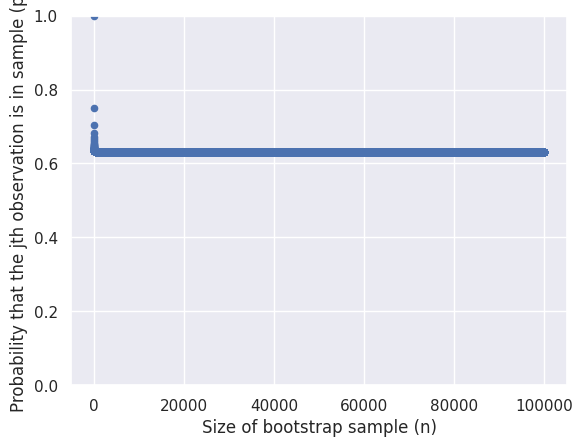

In [7]:
n = np.arange(1, 100_000 + 1)
p = p_in_bootstrap(n)

plt.scatter(n, p, s=20)
plt.ylim([0, 1])
plt.xlabel('Size of bootstrap sample (n)')
plt.ylabel('Probability that the jth observation is in sample (p)');

np.min(p), np.argmin(p)

We can see that this probability rapidly drops somewhere around $63\%$ and stays there no matter how big the sample size gets. 

**(h)** I believe the code provided in the book has a slight error where it samples one point instead of 100, resulting in the estimated probability being the probability of drawing the $j\text{th}$ observation from n points which is $\frac{1}{n}$.

In [8]:
rng = np.random.default_rng(10)
store = np.empty (10000)

for i in range (10000):
    store[i] = np.sum(rng.choice (100, replace=True) == 4) > 0

np.mean(store)

0.0089

To fix it we can pass the keyword argument `size=100` to the `rng.choice()` function so that it returns a sample of size 100.

In [9]:
rng = np.random.default_rng(10)
store = np.empty (10000)

for i in range (10000):
    store[i] = np.sum(rng.choice (100, size=100, replace=True) == 4) > 0

np.mean(store)

0.6362

We can see that the value $63.62\%$ is close to our theoritcal probability value.

It's also worth noting that this probability approaches $1 - \frac{1}{e}$ as $n$ approaches $\infty$ which is easy to show, by taking the limit of $P(not\_in\_bootstrap\_sample)$ as $n$ approaches $\infty$:
$$
\begin{align*}

\lim_{n\to\infty} P(not\_in\_bootstrap\_sample) &= \lim_{n\to\infty} (1 - \frac{1}{n})^n \\
&= \frac{1}{e}
\end{align*}
$$


$$
\begin{align*}
\lim_{n\to\infty}P(in\_bootstrap\_sample) &= 1 - \lim_{n\to\infty}P(not\_in\_bootstrap\_sample) \\
 &= 1 - \frac{1}{e}
\end{align*}
$$ 

In [10]:
1/np.e , 1 - 1/np.e

(0.36787944117144233, 0.6321205588285577)

### **Q3.** 

**(a)** We start by randomly splitting our training set into $k$ groups of almost equal size. Then we train our model on $k - 1$ groups leaving out one to use as the validation set, then calculate the MSE for the model on the held out validation set. We repeat the last step $k$ times but use a different group as the validation set each time. Finally we calculate the average of all $k$ MSE values.

**(b)** The advantages and disadvantages of k-fold cross-validation relative to:

**i.** The validation set approach:

Advantages:

1. Reduced variability for the test error rate estimate compared to the validation set approach.
2. Uses more data points to fit the model which makes it less likely to overestimate the test error rate for the model fit on the entire training data set than the validation set approach.


Disadvantages

1. More computationally expensive as we'd have to fit the model $k$ times opposed to the one time it takes in the validation set approach.


**ii.** LOOCV:

Advantages:

1. Less variance than LOOCV.
2. Less computaionally demanding than LOOCV since we have to fit the model $k$ times instead of $n$ times ($k < n$) where $n$ is the size of the data set.

Disadvantages

1. More biased than LOOCV.


### **Q4.** 

Using the bootstrap method, we start by creating a large number of bootstrap sample data sets say $B = 1000$. Then fit $B$ models on each bootstrap dataset, then using the fitted models we make a prediction on a particular value $x_0$ to get $B$ corresponding predictions, we can call them $\hat{Y}_b$ corresponding to the prediction of the $b\text{th}$ model.

To get the standard deviation of our prediction around $x_0$, we simply calculate the standard deviation of the predictions made using the bootstrap datasets using the following formula:
$$
SE(\hat{Y}) = \sqrt{ \frac{1}{B - 1} \sum^B_{b=1} (\hat{Y}_b - \frac{1}{B} \sum^B_{b'=1} \hat{Y}_{b'})^2 } 
$$

## Applied 

### **Q5.**

In [11]:
default = load_data('Default')
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [12]:
default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   default  10000 non-null  category
 1   student  10000 non-null  category
 2   balance  10000 non-null  float64 
 3   income   10000 non-null  float64 
dtypes: category(2), float64(2)
memory usage: 176.2 KB


In [13]:
np.unique(default['default'], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([9667,  333]))

**(a)**

In [14]:
design = MS(['income', 'balance'])

X = design.fit_transform(default)
y = default['default'] == 'Yes'

glm = sm.GLM(y, 
            X,
            family=sm.families.Binomial())

results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.540500,0.435000,-26.544,0.0
income,0.000021,0.000005,4.174,0.0
balance,0.005600,0.000000,24.835,0.0


**(b)**

In [15]:
design = MS(['income', 'balance'])

X = design.fit_transform(default)
y = default['default'] == 'Yes'

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
lr = sm.GLM(y_train, 
            X_train,
            family=sm.families.Binomial())

results = lr.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.858100,0.528000,-22.477,0.0
income,0.000022,0.000006,3.707,0.0
balance,0.005900,0.000000,21.078,0.0


In [16]:
pred_proba = results.predict(X_valid)
pred_proba.head()

9953    0.000919
3850    0.008410
4962    0.000806
3886    0.003090
5437    0.092877
dtype: float64

In [17]:
pred = np.where(pred_proba > 0.5, 1, 0)
np.unique(pred, return_counts=True)

(array([0, 1]), array([2951,   49]))

In [18]:
conf_mat = confusion_table(pred, y_valid)
conf_mat

Truth,False,True
Predicted,,
False,2893,58
True,16,33


In [19]:
(58+ 16)/conf_mat.sum().sum()

0.024666666666666667

We can see that the validation set error is $2.47\%$.

**(c)** Repeating the process above with 3 different splits:

In [20]:
# helper function that fits the same model above but takes a split_random_state to make a different split of the data
# returns the validation set error
def fit_and_test(split_random_state):

    design = MS(['income', 'balance'])

    X = design.fit_transform(default)
    y = default['default'] == 'Yes'

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=split_random_state)
    results = sm.GLM(y_train, 
                X_train,
                family=sm.families.Binomial()).fit()
    
    pred_proba = results.predict(X_valid)
    pred = np.where(pred_proba > 0.5, 1, 0)
    conf_mat = confusion_table(pred, y_valid)
    return (conf_mat.iloc[0, 1]+ conf_mat.iloc[1, 0])/conf_mat.sum().sum()

In [21]:
fit_and_test(1)

0.024666666666666667

This is the result using the same split used in **(b)**.

In [22]:
fit_and_test(2)

0.023666666666666666

In [23]:
fit_and_test(3)

0.025

In [24]:
fit_and_test(4)

0.025333333333333333

Looking at the validation test errors returned by the 3 different splits, we can see that there's a slight variation between them.

**(d)**

In [25]:
design = MS(['income', 'balance', 'student'])

X = design.fit_transform(default)
y = default['default'] == 'Yes'

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
lr = sm.GLM(y_train, 
            X_train,
            family=sm.families.Binomial())

results = lr.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.142800,0.59400,-18.743,0.000
income,0.000004,0.00001,0.367,0.713
balance,0.005900,0.00000,21.022,0.000
student[Yes],-0.683600,0.28000,-2.440,0.015


In [26]:
pred_proba = results.predict(X_valid)
pred = np.where(pred_proba > 0.5, 1, 0)
conf_mat = confusion_table(pred, y_valid)
conf_mat

Truth,False,True
Predicted,,
False,2895,59
True,14,32


In [27]:
(conf_mat.iloc[0, 1]+ conf_mat.iloc[1, 0])/conf_mat.sum().sum()

0.024333333333333332

Including the dummy variable for `student` led to a very miniscule reduction in the test error rate from $2.47\%$ to $2.43\%$ though that could be a result of the variance, it also made the `income` variable non-statistically significant.

### **Q6.** 

In [28]:
np.random.seed(4)

**(a)**

In [29]:
design = MS(['income', 'balance'])

X = design.fit_transform(default)
y = default['default'] == 'Yes'

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
lr = sm.GLM(y_train, 
            X_train,
            family=sm.families.Binomial())

results = lr.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-11.858100,0.528000,-22.477,0.0
income,0.000022,0.000006,3.707,0.0
balance,0.005900,0.000000,21.078,0.0


In [30]:
results.bse

intercept    0.527555
income       0.000006
balance      0.000278
dtype: float64

We can see the estimaed standard error values for each variable in the table above.  There's a slight difference between the SE of `summarize` and `bse` which is due to how each function estimates it.

Note: `bse` here doesn't stand for "bootstrap standard error", it instead stands for "beta standard error" where beta just refers to the coefficients $\beta_0, \beta_1, ... ,\beta_n$.

**(b)**

In [31]:
def boot_fn(df: pd.DataFrame, idx: np.ndarray):
    design = MS(['income', 'balance'])

    data = df.loc[idx]
    
    X = design.fit_transform(data)
    y = data['default'] == 'Yes'
    
    lr = sm.GLM(y, 
                X,
                family=sm.families.Binomial())

    results = lr.fit()
    return results.params.loc[['income', 'balance']]

In [32]:
rng = np.random.default_rng(0)
boot_fn(default, rng.choice(len(default), 100, replace=True))

income     0.000037
balance    0.005290
dtype: float64

**(c)** Using the `boot_SE` function provided in the chapter 5 lab.

In [33]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

Setting `B = 1000` and estimating the standard error of the parameters.

In [34]:
params_SE = boot_SE(boot_fn, 
                    default, 
                    B=1000,
                    seed=0)
params_SE

income     0.000005
balance    0.000230
dtype: float64

**(d)**

Looking at the values for the standard error using the bootstrap method and the `results.bse` estimates we can see they're not far off.

In [35]:
print(results.bse.__str__().split('\n')[1:])
print(params_SE.__str__().split('\n'))

['income       0.000006', 'balance      0.000278', 'dtype: float64']
['income     0.000005', 'balance    0.000230', 'dtype: float64']


In [36]:
np.abs(results.bse[1:] - params_SE)

income     0.000001
balance    0.000048
dtype: float64

### **Q7.**

In [37]:
weekly = load_data('Weekly')
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [38]:
weekly.describe(include='all')

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Up
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,605
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899,NaN
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927,NaN
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000,NaN
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000,NaN
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000,NaN
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000,NaN


In [39]:
weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Year       1089 non-null   int64   
 1   Lag1       1089 non-null   float64 
 2   Lag2       1089 non-null   float64 
 3   Lag3       1089 non-null   float64 
 4   Lag4       1089 non-null   float64 
 5   Lag5       1089 non-null   float64 
 6   Volume     1089 non-null   float64 
 7   Today      1089 non-null   float64 
 8   Direction  1089 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 69.4 KB


**(a)**


In [40]:
design = MS(['Lag1', 'Lag2'])

X = design.fit_transform(weekly)
y = weekly['Direction'] == 'Up'

glm = sm.GLM(y,
            X,
            family=sm.families.Binomial())

results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2212,0.061,3.599,0.000
Lag1,-0.0387,0.026,-1.477,0.140
Lag2,0.0602,0.027,2.270,0.023



**(b)**


In [41]:
design = MS(['Lag1', 'Lag2'])

X = design.fit_transform(weekly)
y = weekly['Direction'] == 'Up'

X_train = X[1:]
y_train = y[1:]

glm = sm.GLM(y_train, 
            X_train,
            family=sm.families.Binomial())

results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,0.2232,0.061,3.630,0.000
Lag1,-0.0384,0.026,-1.466,0.143
Lag2,0.0608,0.027,2.291,0.022



**(c)**


In [42]:
pred = results.predict(X.iloc[0])
pred

None    0.571392
dtype: float64

$P(Direction = "Up" | Lag1, Lag2) = 0.571392$

Which is greater than $0.5$ which means the model classified that first observation as `Up`.

In [43]:
weekly['Direction'].iloc[0]

'Down'

Unfortunately for our model the first observation's true value was `Down`.

**(d)**


In [44]:
err = np.zeros(weekly.shape[0])
for i in range(1, weekly.shape[0]):
    
    # i
    design = MS(['Lag1', 'Lag2'])

    X = design.fit_transform(weekly)
    y = weekly['Direction'] == 'Up'

    X_train = X.iloc[X.index != i]
    y_train = y.iloc[y.index != i]
    
    X_valid = X.iloc[i]
    y_valid = 'Up' if y.iloc[i] else 'Down' # changing y from boolean to Up if true Down otherwise

    glm = sm.GLM(y_train, 
                X_train,
                family=sm.families.Binomial())

    results = glm.fit()
    
    # ii     
    post_proba = results.predict(X_valid)
    
    # iii
    pred = np.where(post_proba > 0.5, 'Up', 'Down')
    
    # iv
    if pred != y_valid:
        err[i] = 1
    else:
        err[i] = 0

In [45]:
np.unique(err, return_counts=True)

(array([0., 1.]), array([600, 489]))

**(e)**

In [46]:
np.mean(err)

0.4490358126721763

The LOOCV estimate for the test error is $44.9\%$ which is reasonable considering this is a stocks data set.

The following isn't required by the book but I thought I should try verifying the result using the `cross_validate()` function.

In [47]:
from sklearn.metrics import accuracy_score, make_scorer

def error_rate(y_true, y_pred):
    """ 
    Classifies the observation as 1 if the predicted probability is greater than 0.5 and 0 otherwise,
    then returns the error rate in the prediction.
    """
    y_pred = np.where(y_pred > 0.5, 1, 0)
    return 1 - accuracy_score(y_true, y_pred)

custom_scorer = make_scorer(error_rate)

design = MS(['Lag1', 'Lag2'])
glm = sklearn_sm(sm.GLM,
                 model_args={'family':sm.families.Binomial()},
                 model_spec=design)

X = design.fit_transform(weekly)
y = weekly['Direction'] == 'Up'

cv_results = cross_validate(glm,
                            X,
                            y,
                            scoring=custom_scorer,
                            cv=weekly.shape[0])

In [48]:
pd.DataFrame(cv_results).describe()

,fit_time,score_time,test_score
count,1089.000000,1089.000000,1089.000000
mean,0.004592,0.001933,0.449954
std,0.000893,0.000443,0.497718
min,0.004115,0.001664,0.000000
25%,0.004290,0.001753,0.000000
50%,0.004378,0.001806,0.000000
75%,0.004580,0.001903,1.000000
max,0.018796,0.008757,1.000000


In [49]:
cv_err = np.mean(cv_results['test_score'])
cv_err

0.44995408631772266

We can see that the two values are very close to eachother.

In [50]:
cv_err, np.mean(err)

(0.44995408631772266, 0.4490358126721763)

### **Q8.**

**(a)**  

In [51]:
rng = np.random.default_rng(1)
x = rng.normal(size =100)
y = x - 2 * x**2 + rng.normal(size =100)

The population size $n = 100$ and the number of predictors is $p = 2$, $X$ and $X^2$ . 
$$
X\sim N(0, 1) \\
$$
$$
Y = X - 2 * X^2 + \epsilon \\
$$

**(b)**

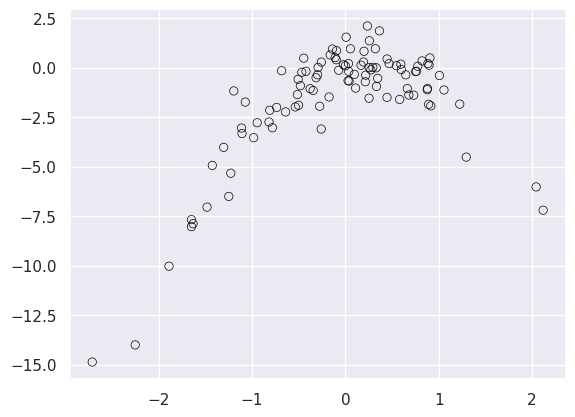

In [52]:
plt.scatter(x, y, marker='o', facecolors='none', edgecolors='black', linewidths=0.5);

We can see an obvious quadratic relationship in the data.

**(c)**

In [53]:
seed = 2025

cv = KFold(n_splits=x.shape[0],
           shuffle=True,
           random_state=seed) 

cv_error = np.zeros(4)
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,5)):
    X = np.power.outer(x, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

We get the above LOOCV error rates for the linear, quadratic, cubic, and quartic models respectively.

**(d)** Setting the seed to `162` and running the code again.

In [54]:
seed = 1984


cv = KFold(n_splits=x.shape[0],
           shuffle=True,
           random_state=seed) 

cv_error = np.zeros(4)
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,5)):
    X = np.power.outer(x, np.arange(d+1))
    M_CV = cross_validate(M,
                          X,
                          y,
                          cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error

array([6.63302984, 1.12293686, 1.30179655, 1.33239427])

We can see that we got the exact same results as (c). Because LOOCV isn't a random process, it treats all points in the data set equally where it uses each as a test point in one iteration, and as training points in `n-1` iterations.

**(e)** The quadratic model had the lowest LOOCV error rate of $1.1229$ which was expected because the true underlying model $Y = X - 2 X^2 + \epsilon$ is quadratic.

**(f)**

In [55]:
for i, d in enumerate(range(1,5)):
    X = np.power.outer(x, np.arange(d+1))
    results = sm.OLS(y, X).fit()
    print(summarize(results))
    print()

         coef  std err      t  P>|t|
const -1.4650    0.247 -5.937    0.0
x1     1.9494    0.289  6.752    0.0

         coef  std err       t  P>|t|
const -0.0728    0.119  -0.611  0.543
x1     0.9663    0.126   7.647  0.000
x2    -2.0047    0.091 -22.072  0.000

         coef  std err       t  P>|t|
const -0.0572    0.120  -0.477  0.635
x1     1.1146    0.187   5.945  0.000
x2    -2.0471    0.099 -20.673  0.000
x3    -0.0643    0.060  -1.070  0.287

         coef  std err       t  P>|t|
const  0.1008    0.136   0.743  0.460
x1     0.9050    0.205   4.423  0.000
x2    -2.5059    0.221 -11.336  0.000
x3     0.0338    0.073   0.466  0.642
x4     0.1042    0.045   2.309  0.023



After fitting all 4 polynomial models we can see that only the linear and quadratic terms were statistically significant in the models they were in which agrees with our conclusions drawn from cross validation, which suggest that the quadratic model minimises the CV error (The linear model is included due to the heirarchical principle).

### **Q9.**

In [56]:
boston = load_data('Boston')
boston.head() 

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [57]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [58]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


**(a)** 

In [59]:
medv_mean = boston.describe()['medv'].loc['mean']
medv_mean

22.532806324110677

$$
\hat \mu = 22.5328
$$

**(b)** 
$$
\hat{SE}(\hat\mu) = \frac{\hat\sigma}{\sqrt{n}}
$$

In [60]:
medv_mean_SE = boston['medv'].std()/np.sqrt(boston.shape[0])
medv_mean_SE

0.40886114749753505

$$
\hat{SE}(\hat\mu) = 0.40886
$$

**(c)** Estimating the standard error of $\hat\mu$ using the bootstrap:

In [61]:
def boot_fn(df, idx):
    return np.mean(df.iloc[idx])

# same bootstrap function from Lab5
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,
                         n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)

In [62]:
medv_mean_boot_SE = boot_SE(boot_fn, 
                        boston['medv'],
                        B=10000,
                        seed=1)
medv_mean_boot_SE

0.40976659164537216

We can see that with `B=10000` our bootstrap estimate for $ \hat{SE}(\hat\mu) = 0.40977$ which isn't far off from the value we got in **(b)**.

**(d)** To find the $95\%$ confidence interval we use this formula:
$$
\hat\mu \pm 2 \hat{SE}(\hat\mu)
$$

Using the bootstrap estimate:

In [63]:
medv_mean - 2 * medv_mean_boot_SE, medv_mean + 2 * medv_mean_boot_SE

(21.713273140819933, 23.35233950740142)

Using the estimate we got from the formula $\frac{\hat\sigma}{\sqrt{n}}$:

In [64]:
medv_mean - 2 * medv_mean_SE, medv_mean + 2 * medv_mean_SE

(21.715084029115605, 23.35052861910575)

**(e)**

In [65]:
boston['medv'].median()

21.2

$$
\hat{\mu}_{med} = 21.2
$$


**(f)** We'll use the same `boot_SE` function above we'll only make a slight adjustment to the `boot_fn` to calculate the median instead of the mean.

In [66]:
def boot_fn(df, idx):
    return np.median(df.iloc[idx])

In [67]:
medv_med_boot_SE = boot_SE(boot_fn, 
                        boston['medv'],
                        B=10000,
                        seed=1)
medv_med_boot_SE

0.37954976997614637

We can see that with `B=10000` our bootstrap estimate for $ \hat{SE}(\hat{\mu}_{med}) = 0.3795$.

**(g)** Using the `np.percentile()` method to find the tenth percentile of `medv`.

In [68]:
np.percentile(boston['medv'], 10)

12.75

$$
\hat{\mu}_{0.1} = 12.75
$$

**(h)** Same `boot_SE` function as above, slight adjustment to `boot_fn` to calculate tenth percentiles. 

In [69]:
def boot_fn(df, idx):
    return np.percentile(df.iloc[idx], 10)

In [70]:
boot_SE(boot_fn,
        boston['medv'],
        B=10000,
        seed=1)

0.5079360794215755

$$
\hat{SE}(\hat{\mu}_{0.1}) = 0.50794
$$

Not sure what to comment on here other than report the value.